In [5]:
from IPython.display import display
import numpy as np
from numpy import array, exp, zeros, sqrt
from numpy.linalg import norm
from matplotlib import pyplot as plt
import pandas as pd
from scipy.special import ellipj

def npPrint(a, f={'float_kind': lambda x: "%.5e" % x}): # defining common functions from quiz
    print(np.array2string(a, formatter=f))


def forwardEuler(f, Df, t0, y0, h): 
    return y0 + h * f(t0, y0)


def Q11( f,Df, t0,y0, h):
    f0 = f(t0,y0)
    f1 = f(t0+h, y0+h*f0)
    return y0 + h/2*(f0+f1)


def backwardEuler(f, Df, t0, y0, h):
    m = len(y0)
    F = lambda y: y - f(t0+h, y0 + h*y)
    DF = lambda y: np.eye(m) - h*Df(t0+h, y0 +h*y)
    y, _ = newton(F, DF, f(t0+h, y0),h*h*1e-5, 1000)
    return y0+h*y


def sIEuler(f, Df, t0, y0, h):
    x1 = y0[0] + h*y0[1]
    p1 = y0[1] + h*f(t0, np.array([x1,y0[1]]))[1]
    return np.array([x1,p1])

    
def crankNicholson(f, Df, t0, y0, h):
    m = len(y0)
    F = lambda x: x - ((1/2) * (f(t0, y0) + f(t0+h, y0+h*x)))
    DF = lambda x: np.eye(m) - ((1/2) * h * Df(t0+h, y0+h*x))
    x, k = newton(F, DF, f(t0+h, y0), h**2*1e-5,1000)
    y = y0 + h*x
    return y


def evolve(phi, f, Df, t0, y0, T, N):
    h = T / N
    n = np.arange(0, N + 1, 1)
    t = h * n
    y = np.zeros((N + 1, len(y0)))
    y[0] = y0
    for n in range(N):
        y[n + 1] = phi(f, Df, t[n], y[n], h)
    return t, y


def computeEocs(herr):
    eocs = np.zeros(0)
    h = herr[:, 0]
    e = herr[:, 1]
    i = 0
    while i < np.size(herr, 0) - 1:
        eocs = np.append(eocs, np.log(e[i + 1] / e[i]) / np.log(h[i + 1] / h[i]))
        i += 1
    return eocs


def newton(F, DF, x0, eps, K):
    x = x0
    k = 0
    while k < K:
        dx = np.linalg.solve(DF(x),-F(x))
        x += dx
        k += 1
        if np.linalg.norm(F(x)) < eps:
            break
    return x, k


def fIEuler(f, Df, t0, y0, h): # fully implicit method
    x0 = y0[0]
    p0 = y0[1]
    F = lambda d: d - p0 + (1/(2*d)) * (V(h*d+x0) -V(x0)) 
    DF = lambda d: 1 +  1/(2*(d**2)) * (h*d*DV(x0 + h*d) - V(x0+h*d)+V(x0))
    d, k = newtonScalar(F, DF, V(x0+h), h*h*1e-5, 1000)
    x1 = x0 + h*d
    p1 = p0 - h*(V(x1)- V(x0))/(x1-x0)
    return np.array([x1,p1])


def newtonScalar(F, DF, x0, eps, K):  # for scalar fully implciit method
    x = x0
    k = 0
    while k < K:
        dx = F(x)/DF(x)
        x -= dx
        k += 1
        if np.linalg.norm(F(x)) < eps:
            break
    return x, k


def experiment(stepper, plot, question2):
    M  = 11
    herr = zeros( [M,2] )
    ystore = np.zeros(0)
    relError = zeros( [M,1] )
    for m in range(M):
        N = N0*2**m
        t,y = evolve(stepper, f,Df, 0,Y(0),T, N)
        herr[m] = [T/N, 0]
        maxError = 0.
        for tn,yn in zip(t,y):
            herr[m][1] = max(herr[m][1], norm(yn-Y(tn)))
        if plot:
            if (m == 0):
                y0store = y
            if m == 1:
                y1store = y
        if question2: # only applies for hamiltonian errors
            for yn in y:
                error = np.abs(H(t0,yn)-H(t0, Y(0))) / np.abs(H(t0,Y(0)))
                maxError = max(maxError, error)
            relError[m] = maxError
    
    eoc = computeEocs( herr )
    eoc = np.hstack( [ [np.nan],eoc ])
    if question2:
        res = np.hstack( [herr, np.atleast_2d(eoc).T, relError])
    else:
        res = np.hstack( [herr, np.atleast_2d(eoc).T])
    if plot:
        return y0store, y1store
    else:
        return res


def compareErrors(results, question2):
    # columns of table
    simul = list(results.keys())
    if not question2:
        columns=['h'] + [s for n in simul for s in [f'{n}-Error', f'{n}-EOC']]
    if question2:
        columns=['h'] + [s for n in simul for s in [f'{n}-Error', f'{n}-EOC',f'{n}-Rel Err']]
    # values in tablea
    keys   = {columns[0]: results[simul[0]][:,0]} # all results are assumed to use the same sequence of h
    styles = {columns[0]: '{:.4e}'}
    if not question2:
        for i, k in enumerate(simul):
            keys[columns[2*i+1]]   = results[k][:,1] # errors
            styles[columns[2*i+1]] = '{:.6e}'
            keys[columns[2*i+2]]   = results[k][:,2] # eocs
            styles[columns[2*i+2]] = '{:.3f}'
    elif question2:
        for i, k in enumerate(simul):
            keys[columns[3*i+1]]   = results[k][:,1] # errors
            styles[columns[3*i+1]] = '{:.6e}'
            keys[columns[3*i+2]]   = results[k][:,2] # eocs
            styles[columns[3*i+2]] = '{:.3f}'
            keys[columns[3*i+3]]   = results[k][:,3] # eocs
            styles[columns[3*i+3]] = '{:.6e}'

    # generate table
    table = pd.DataFrame(keys, index=range(results[simul[0]].shape[0]), # all results must have the same shape
            columns=columns)

    # format floating points for each column for jupyter output (does not work in pdf)
    display( table.style.format(styles) )

    for i,k in enumerate(simul):
        plt.loglog(results[k][:,0],results[k][:,1],marker='o',label=k)
    plt.legend()
    plt.grid(True)
    plt.xlabel("step size h")
    plt.ylabel("Maximum error over time")
    plt.savefig("Q2_compareErr.pdf", format="pdf", bbox_inches="tight") # output to pdf for inclusing in tex document
    plt.show()
    

def plotting(function):
    y0store, y1store = experiment(function, True, False)
    plt.figure()
    plt.plot(y0store[:,0], y0store[:,1], label = 'N = 150')
    plt.plot(y1store[:,0], y1store[:,1], label = 'N = 300')
    plt.xlim(-1.3,1.3)
    plt.ylim(-1.3,1.3)
    plt.title({function})
    plt.legend()
    plt.xlabel('x (Position)')
    plt.ylabel('p (Momentum)')
    
    plt.show()    

We define a few more functions this time, especially to help with plotting. Below we define our numerical analysis functions too.

In [6]:
T = 10
N0 = 25
Y = lambda t: array([2*exp(t)/(2*exp(t)-1),
                     (-2*exp(t))/(4*exp(2*t)-4*exp(t)+1)])
def f(t,y):
    return array([y[1], y[1]*(1-2*y[0])])
def Df(t,y):
    return array([[0,1],[-2*y[1],1-2*y[0]]])

,h,FE-Error,FE-EOC,BE-Error,BE-EOC,Q11-Error,Q11-EOC,CN-Error,CN-EOC
0,4.0000e-01,1.197520e+00,nan,4.596387e+00,nan,2.336009e-01,nan,1.853746e-01,nan
1,2.0000e-01,3.849013e-01,1.637,1.949440e-01,4.559,5.724377e-02,2.029,4.250296e-02,2.125
2,1.0000e-01,1.424462e-01,1.434,1.058020e-01,0.882,1.252991e-02,2.192,1.013313e-02,2.068
3,5.0000e-02,6.525497e-02,1.126,5.635233e-02,0.909,2.894328e-03,2.114,2.522717e-03,2.006
4,2.5000e-02,3.135656e-02,1.057,2.914622e-02,0.951,6.889803e-04,2.071,6.287615e-04,2.004
5,1.2500e-02,1.538350e-02,1.027,1.483127e-02,0.975,1.680073e-04,2.036,1.571657e-04,2.000
6,6.2500e-03,7.620535e-03,1.013,7.482302e-03,0.987,4.148271e-05,2.018,3.928423e-05,2.000
7,3.1250e-03,3.792678e-03,1.007,3.758094e-03,0.993,1.030578e-05,2.009,9.820607e-06,2.000
8,1.5625e-03,1.891968e-03,1.003,1.883324e-03,0.997,2.568356e-06,2.005,2.455153e-06,2.000
9,7.8125e-04,9.448989e-04,1.002,9.427381e-04,0.998,6.410798e-07,2.002,6.137861e-07,2.000


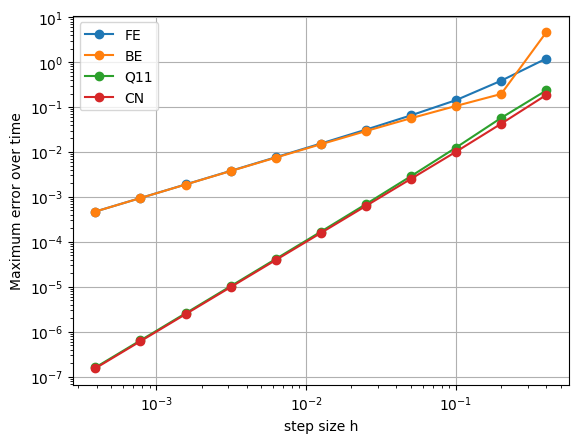

In [7]:
forwardEulerComp = experiment(forwardEuler, False, False)
Q11Comp = experiment(Q11, False, False)
backwardEulerComp = experiment(backwardEuler, False, False)
crankNicholsonComp = experiment(crankNicholson, False, False)

compareErrors({"FE":forwardEulerComp,"BE":backwardEulerComp,"Q11":Q11Comp,"CN":crankNicholsonComp}, False)

,h,BE-Error,BE-EOC,BE-Rel Err,Q11-Error,Q11-EOC,Q11-Rel Err,CN-Error,CN-EOC,CN-Rel Err,SIE-Error,SIE-EOC,SIE-Rel Err,FIE-Error,FIE-EOC,FIE-Rel Err
0,2.6667e-01,9.964571e-01,nan,9.999665e-01,4.920079e-01,nan,2.086570e-01,2.340019e-01,nan,6.854272e-07,2.516098e-01,nan,1.538396e-01,2.340031e-01,nan,1.858450e-10
1,1.3333e-01,9.309637e-01,0.098,9.949405e-01,1.191125e-01,2.046,2.398591e-02,5.909267e-02,1.985,5.080120e-08,9.588617e-02,1.392,7.142441e-02,5.909313e-02,1.985,1.062757e-10
2,6.6667e-02,7.362502e-01,0.339,9.301048e-01,2.964800e-02,2.006,2.967350e-03,1.480481e-02,1.997,5.759234e-09,4.063059e-02,1.239,3.448274e-02,1.480481e-02,1.997,4.840572e-13
3,3.3333e-02,4.865085e-01,0.598,7.362077e-01,7.407921e-03,2.001,3.704389e-04,3.703096e-03,1.999,4.851010e-09,1.848764e-02,1.136,1.694891e-02,3.703084e-03,1.999,7.036927e-12
4,1.6667e-02,2.834529e-01,0.779,4.865353e-01,1.851863e-03,2.000,4.629737e-05,9.259273e-04,2.000,1.975313e-09,8.788152e-03,1.073,8.403348e-03,9.258873e-04,2.000,1.321165e-13
5,8.3333e-03,1.535157e-01,0.885,2.834604e-01,4.629630e-04,2.000,5.787054e-06,2.314816e-04,2.000,1.234608e-10,4.280311e-03,1.038,4.184016e-03,2.314791e-04,2.000,9.325873e-15
6,4.1667e-03,7.995523e-02,0.941,1.535171e-01,1.157407e-04,2.000,7.233799e-07,5.787038e-05,2.000,7.716494e-12,2.111746e-03,1.019,2.087683e-03,5.787022e-05,2.000,2.775558e-14
7,2.0833e-03,4.081050e-02,0.970,7.995542e-02,2.893518e-05,2.000,9.042246e-08,1.446759e-05,2.000,4.813927e-13,1.048769e-03,1.010,1.042752e-03,1.446758e-05,2.000,1.099121e-14
8,1.0417e-03,2.061781e-02,0.985,4.081052e-02,7.233796e-06,2.000,1.130282e-08,3.616898e-06,2.000,3.241851e-14,5.226089e-04,1.005,5.211047e-04,3.616898e-06,2.000,1.643130e-14
9,5.2083e-04,1.036260e-02,0.993,2.061782e-02,1.808449e-06,2.000,1.412853e-09,9.042245e-07,2.000,2.120526e-14,2.608605e-04,1.002,2.604845e-04,9.042839e-07,2.000,3.108624e-14


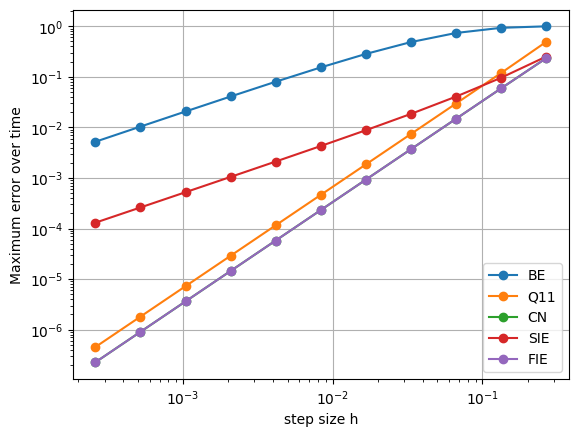

In [8]:
Y = lambda t: np.array([np.sin(t), np.cos(t)])


def H(t,y):
    x, p = y[0], y[1]
    V = 0.5 * (k**2+1) * x**2 - 0.5*((k*x)**2)
    return 0.5 * p**2 + V


def f(t,y):
    return np.array([y[1], -(k**2 + 1)*y[0] + (r/2)*(k**2)*(y[0]**(r-1))])


def Df(t,y):
    return np.array([[0,1],[-(k**2+1)+ r*(r-1)*(k**2) * (y[0]**(r-2)),0]])


def V(x):
    return (((k**2)+1)/2)*(x**2) - ((k**2)/2)*(x**r)


def DV(x):
    return ((k**2)+1)*x - ((r*(k**2))/2)*(x**(r-1))


T = 40
k = 0.8
N0 = 150
t0 = 0
r=2


def fullExperiment():
    Q11Comp = experiment(Q11, False, True)
    backwardEulerComp = experiment(backwardEuler, False, True)
    crankNicholsonComp = experiment(crankNicholson, False, True)
    sIEulerComp = experiment(sIEuler, False, True)
    fIEulerComp = experiment(fIEuler, False, True)
    compareErrors({"BE":backwardEulerComp,"Q11":Q11Comp,"CN":crankNicholsonComp, "SIE":sIEulerComp, "FIE":fIEulerComp}, True)

    
def fullPlot():    
    plotting(backwardEuler)
    plotting(Q11)
    plotting(crankNicholson)
    plotting(sIEuler)
    plotting(fIEuler)
    
fullExperiment()

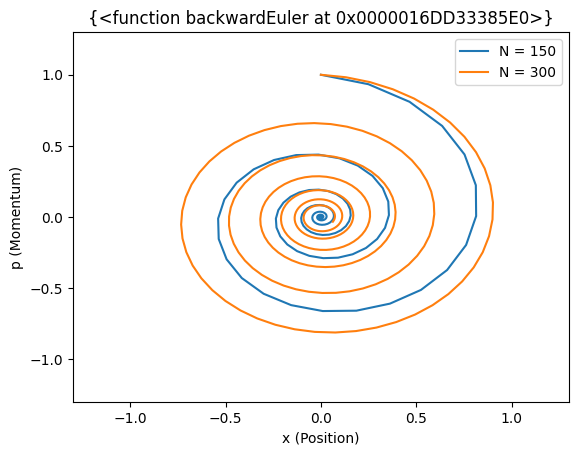

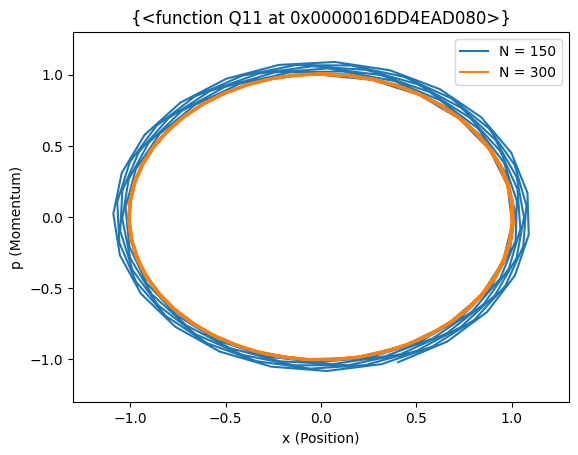

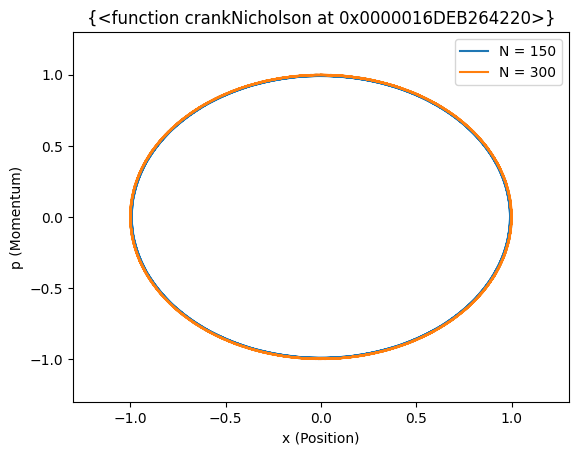

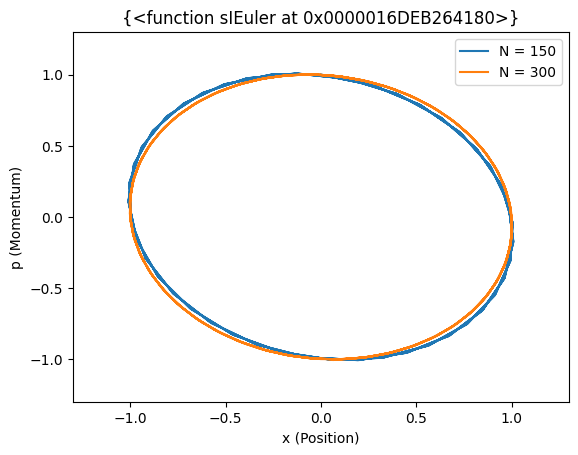

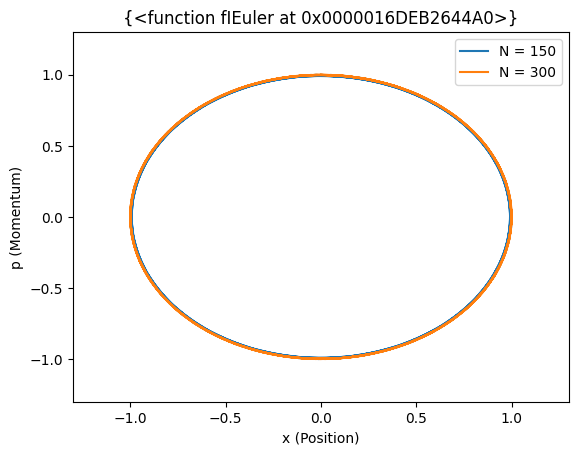

In [9]:
fullPlot()

C:\Users\harve\AppData\Local\Temp\ipykernel_27908\3804893376.py:11: RuntimeWarning: overflow encountered in scalar power
  return np.array([y[1], -(k**2 + 1)*y[0] + (r/2)*(k**2)*(y[0]**(r-1))])
C:\Users\harve\AppData\Local\Temp\ipykernel_27908\3804893376.py:11: RuntimeWarning: invalid value encountered in scalar add
  return np.array([y[1], -(k**2 + 1)*y[0] + (r/2)*(k**2)*(y[0]**(r-1))])
C:\Users\harve\AppData\Local\Temp\ipykernel_27908\3804893376.py:6: RuntimeWarning: overflow encountered in scalar power
  V = 0.5 * (k**2+1) * x**2 - 0.5*((k*x)**2)
C:\Users\harve\AppData\Local\Temp\ipykernel_27908\3804893376.py:6: RuntimeWarning: invalid value encountered in scalar subtract
  V = 0.5 * (k**2+1) * x**2 - 0.5*((k*x)**2)
C:\Users\harve\AppData\Local\Temp\ipykernel_27908\1319594711.py:63: RuntimeWarning: divide by zero encountered in log
  eocs = np.append(eocs, np.log(e[i + 1] / e[i]) / np.log(h[i + 1] / h[i]))


,h,BE-Error,BE-EOC,BE-Rel Err,Q11-Error,Q11-EOC,Q11-Rel Err,CN-Error,CN-EOC,CN-Rel Err,SIE-Error,SIE-EOC,SIE-Rel Err,FIE-Error,FIE-EOC,FIE-Rel Err
0,2.6667e-01,1.245470e+00,nan,9.999999e-01,inf,nan,4.756569e+230,1.671304e+00,nan,1.453168e-01,1.806380e+00,nan,2.486538e-01,1.311912e-01,nan,1.600003e-01
1,1.3333e-01,1.391192e+00,-0.160,9.997683e-01,1.586126e+00,inf,1.547942e-01,5.155159e-01,1.697,1.563333e-01,5.503766e-01,1.715,2.105791e-01,3.302571e-02,1.990,1.599952e-01
2,6.6667e-02,1.651777e+00,-0.248,9.810943e-01,3.242903e-01,2.290,1.585814e-01,1.270670e-01,2.020,1.590827e-01,1.347051e-01,2.031,1.863784e-01,8.266260e-03,1.998,1.599998e-01
3,3.3333e-02,1.777689e+00,-0.106,8.495854e-01,5.871152e-02,2.466,1.597389e-01,3.153818e-02,2.010,1.597712e-01,3.330688e-02,2.016,1.734646e-01,2.067661e-03,1.999,1.599992e-01
4,1.6667e-02,1.797906e+00,-0.016,6.031110e-01,1.201850e-02,2.288,1.599385e-01,7.868376e-03,2.003,1.599428e-01,8.303854e-03,2.004,1.668012e-01,5.169790e-04,2.000,1.599999e-01
5,8.3333e-03,1.865162e+00,-0.053,3.812702e-01,2.677790e-03,2.166,1.599847e-01,1.966079e-03,2.001,1.599857e-01,2.971172e-03,1.483,1.634184e-01,1.292527e-04,2.000,1.600000e-01
6,4.1667e-03,1.940380e+00,-0.057,2.612163e-01,6.288111e-04,2.090,1.599963e-01,4.914603e-04,2.000,1.599964e-01,1.487067e-03,0.999,1.617135e-01,3.231534e-05,2.000,1.600000e-01
7,2.0833e-03,1.535497e+00,0.338,2.090865e-01,1.521329e-04,2.047,1.599991e-01,1.228589e-04,2.000,1.599991e-01,7.439090e-04,0.999,1.608578e-01,8.079454e-06,2.000,1.600000e-01
8,1.0417e-03,1.013199e+00,0.600,1.843763e-01,3.739999e-05,2.024,1.599998e-01,3.071436e-05,2.000,1.599998e-01,3.720478e-04,1.000,1.604292e-01,2.020129e-06,2.000,1.600000e-01
9,5.2083e-04,5.788232e-01,0.808,1.711940e-01,9.270870e-06,2.012,1.599999e-01,7.678565e-06,2.000,1.599999e-01,1.860472e-04,1.000,1.602147e-01,5.051000e-07,2.000,1.600000e-01


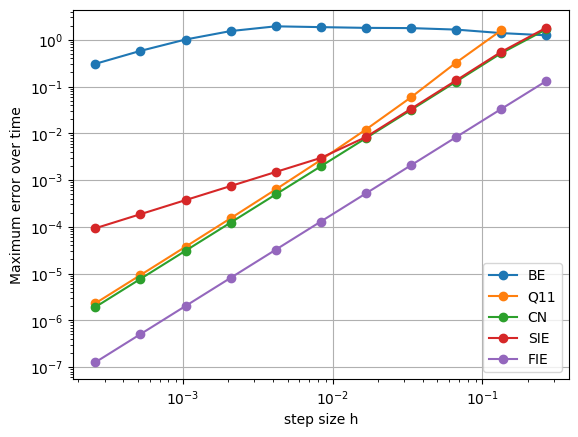

In [10]:
def Y(t):
    sn , cn , dn , _ = ellipj (t, k*k)
    return array ([ sn , cn * dn ]) # (x(t) ,p(t))

r = 4

fullExperiment()

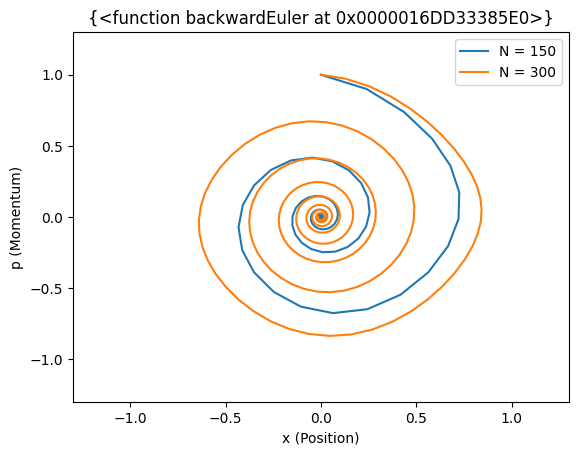

C:\Users\harve\AppData\Local\Temp\ipykernel_27908\3804893376.py:11: RuntimeWarning: overflow encountered in scalar power
  return np.array([y[1], -(k**2 + 1)*y[0] + (r/2)*(k**2)*(y[0]**(r-1))])
C:\Users\harve\AppData\Local\Temp\ipykernel_27908\3804893376.py:11: RuntimeWarning: invalid value encountered in scalar add
  return np.array([y[1], -(k**2 + 1)*y[0] + (r/2)*(k**2)*(y[0]**(r-1))])
C:\Users\harve\AppData\Local\Temp\ipykernel_27908\1319594711.py:63: RuntimeWarning: divide by zero encountered in log
  eocs = np.append(eocs, np.log(e[i + 1] / e[i]) / np.log(h[i + 1] / h[i]))


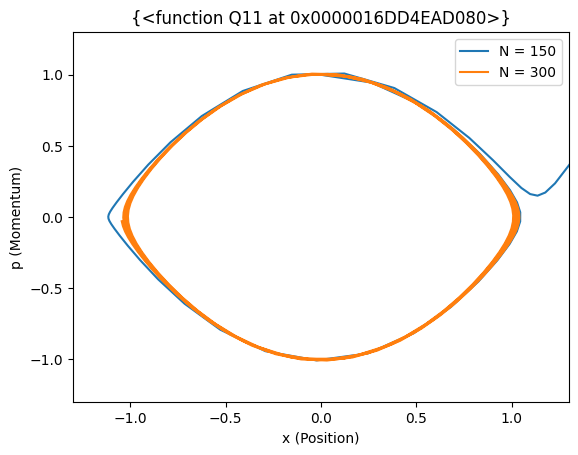

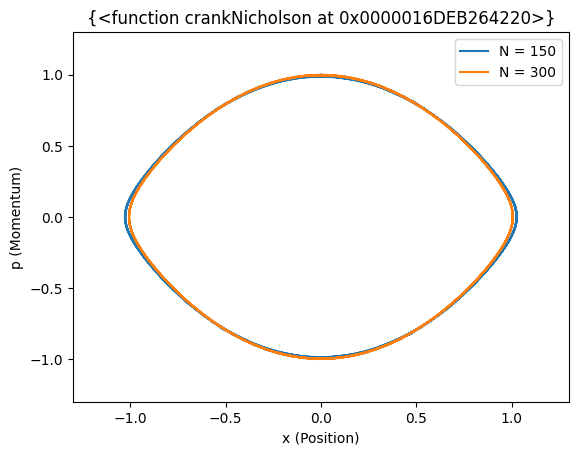

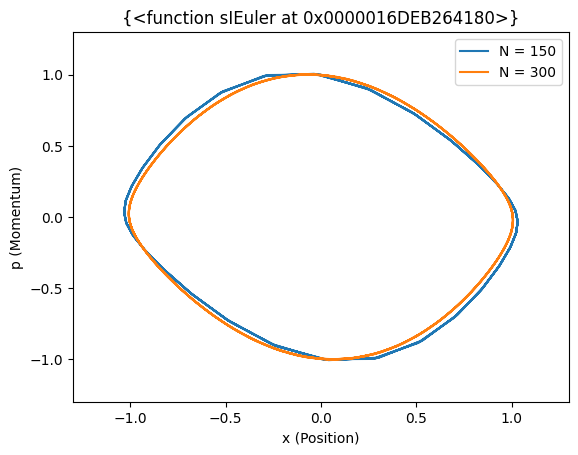

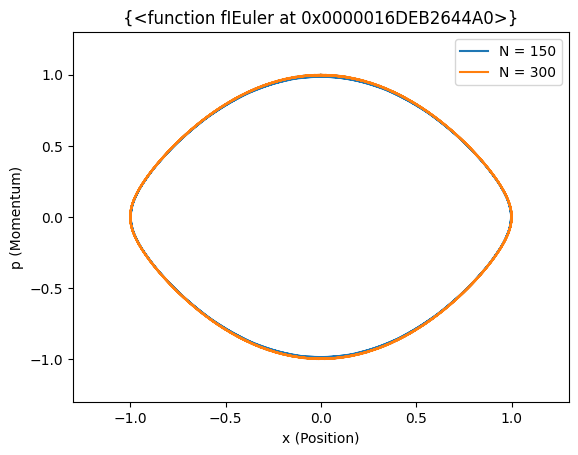

In [11]:
fullPlot()

So we can see that the semi-explicit Euler Method has a convergence rate of 1, whereas the fully-implicit version has a convergence rate of 2 meaning it is more efficient in terms of reaching our desired values faster. 

In the r=2 case, the relative errors decreased much more for the second order methods in the following order from smallest to largest: crank nicholson, fully implicit, Q11, backward euler, semi implicit, and the first three had significantly smaller relative errors.

In the r=4 case, the relative errors all converge to 0.16 approximately, however it's clear that the second order methods converge much faster again. For example, at m=5, the fully implicit method has a relative error of 0.16 but the backward euler method still doesn't reach 0.16 by the final round. 

The relative errors converged (from fastest to slowest): fully implicit, crank Nicholson, Q11, backward Euler, semi implicit. 
I would use this as justification for fully implicit or crank nicholson being the most effective. On the other hand, these methods are particularly demanding, causing longer runtimes for the notebook. 

I used an initial guess for Newton's method of V(x0 + h) since it would be quite close to V(x) which would hopefully give good results.